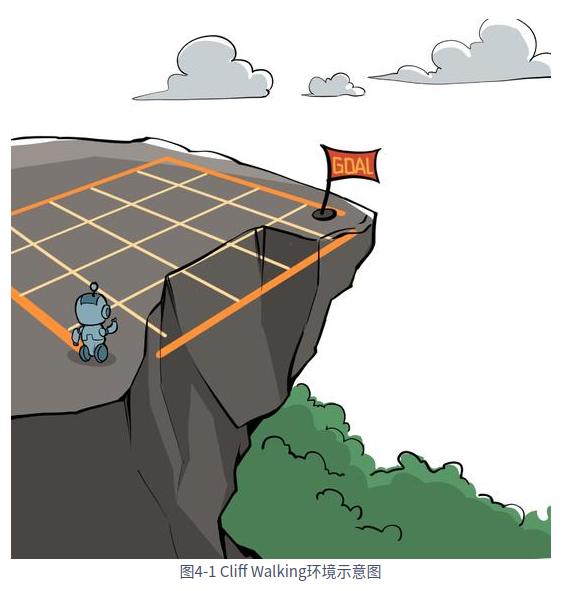  

$$\begin{bmatrix}
A & A & A & ... & A & A
\\ A & A & A & ... & A & A
\\ A & A & A & ... & A & A
\\ S & B & B & ... & B & E
\end{bmatrix}$$

X方向：$\rightarrow$   
Y方向：$\uparrow$  
A表示可行，B表示悬崖,S表示起点，E表示终点  
对于所有的环境，必须包含状态转移矩阵，形状为(states,actions,next_states_data,4)  
其中next_states_data是一个tuple包含四个内容:(状态转移概率，下一状态，奖励值，终止与否)  


In [33]:
import copy


class CliffWalkingEnv:
    """ 悬崖漫步环境"""
    def __init__(self, ncol=12, nrow=4):
        self.ncol = ncol  # 定义网格世界的列
        self.nrow = nrow  # 定义网格世界的行
        # 转移矩阵P[state][action] = [(p, next_state, reward, done)]包含下一个状态和奖励
        self.P = self.createP()

    def createP(self):
        # 初始化
        P = [[[] for j in range(4)] for i in range(self.nrow * self.ncol)]
        # row*col种状态[row*col]
        # 每个状态有4种动作, change[0]:上,change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)[[4],[4],...row*col]
        # 每个动作会进行状态转移，包含四个信息,[[[(p, next_state, reward, done)],[()],[()],[()]],[4],...row*col]
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        for i in range(self.nrow):
            for j in range(self.ncol):
                for a in range(4):
                    # 位置在悬崖或者目标状态,因为无法继续交互,任何动作奖励都为0
                    if i == self.nrow - 1 and j > 0:
                        P[i * self.ncol + j][a] = [(1, i * self.ncol + j, 0, True)]
                        continue
                    # 其他位置
                    next_x = min(self.ncol - 1, max(0, j + change[a][0]))
                    # max表示不会超过最小边界，min不会超过最大边界
                    next_y = min(self.nrow - 1, max(0, i + change[a][1]))
                    next_state = next_y * self.ncol + next_x
                    reward = -1
                    done = False
                    # 下一个位置在悬崖或者终点
                    if next_y == self.nrow - 1 and next_x > 0:
                        done = True
                        if next_x != self.ncol - 1:  # 下一个位置在悬崖
                            reward = -100
                    P[i * self.ncol + j][a] = [(1, next_state, reward, done)]
        return P
    

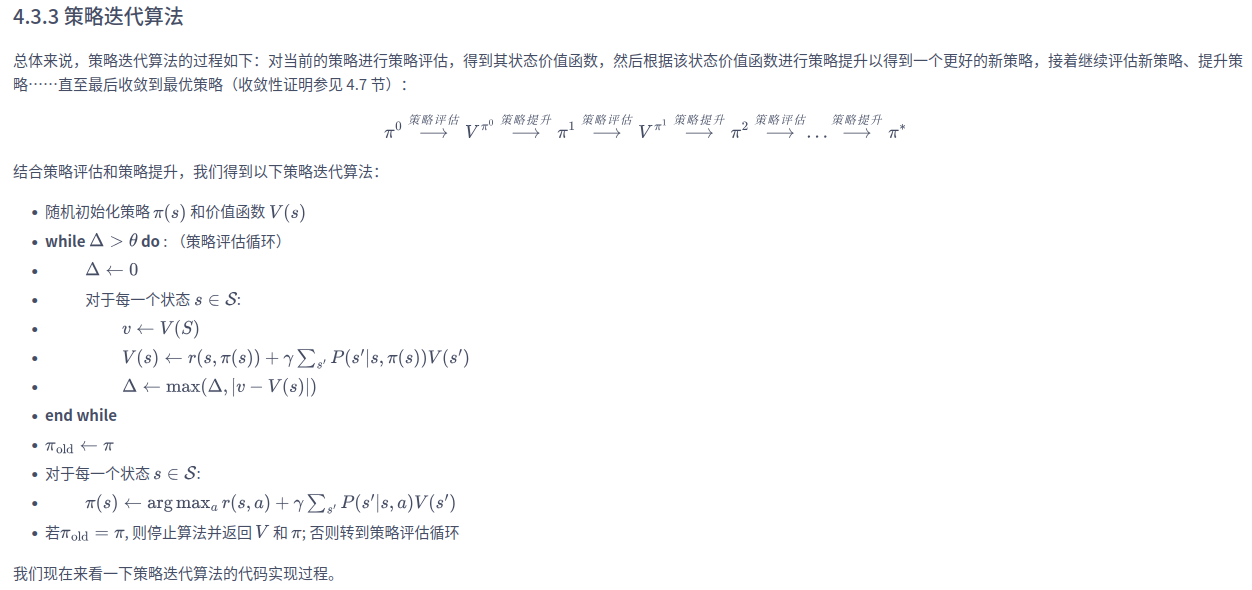

In [34]:
class PolicyIteration:
    """ 策略迭代算法 """
    def __init__(self, env, theta, gamma):
        self.env = env
        # 列表乘法 list * n 只是重复列表元素，不会改变维度
        self.v = [0] * self.env.ncol * self.env.nrow  # 初始化价值为0，一维
        self.pi = [[0.25, 0.25, 0.25, 0.25]
                   for i in range(self.env.ncol * self.env.nrow)]  # 初始化为均匀随机策略
        # 二维list，行表示状态，列表示每个action的概率
        self.theta = theta  # 策略评估收敛阈值

        self.gamma = gamma  # 折扣因子

    # 计算某个状态的所有Q_value(s_i,a)
    def action_value_per_state(self,state):
        qsa_list = []
        for a in range(4):
            qsa = 0
            for res in self.env.P[state][a]:
                p, next_state, r, done = res
                # 这里采取某一动作就一定会转移到指定状态，终点或者悬崖状态不转移，奖励为0，动作值也为0
                qsa += p * (r + self.gamma * self.v[next_state] *(1 - done))
                # 本章环境比较特殊,奖励和下一个状态有关,所以需要和状态转移概率相乘，悬崖问题概率是1
            qsa_list.append(qsa)
        return qsa_list

    def policy_evaluation(self):  # 策略评估
        cnt = 1  # 计数器
        while 1:
            max_diff = 0
            new_v = [0] * self.env.ncol * self.env.nrow
            for s in range(self.env.ncol * self.env.nrow):
                # 开始计算状态s下的所有Q(s,a)价值
                qsa_list = self.action_value_per_state(s)  
                # 计算概率加权值
                qsa_list = [qsa * self.pi[s][i] for i, qsa in enumerate(qsa_list)]
                new_v[s] = sum(qsa_list)  # 状态价值函数和动作价值函数之间的关系
                max_diff = max(max_diff, abs(new_v[s] - self.v[s]))
            self.v = new_v
            if max_diff < self.theta: break  # 满足收敛条件,退出评估迭代
            cnt += 1
        print("策略评估进行%d轮后完成" % cnt)
    



    def policy_improvement(self):  # 策略提升
        for s in range(self.env.nrow * self.env.ncol):
            qsa_list=self.action_value_per_state(s)
            maxq = max(qsa_list)
            cntq = qsa_list.count(maxq)  # 计算有几个动作得到了最大的Q值
            # 让这些动作均分概率
            self.pi[s] = [1 / cntq if q == maxq else 0 for q in qsa_list]
        print("策略提升完成")
        return self.pi


    def policy_iteration(self):  # 策略迭代
        while 1:
            self.policy_evaluation()
            old_pi = copy.deepcopy(self.pi)  # 将列表进行深拷贝,方便接下来进行比较
            new_pi = self.policy_improvement()
            if old_pi == new_pi: break

In [35]:
def print_agent(agent, action_meaning, disaster=[], end=[]):
    print("状态价值：")
    for i in range(agent.env.nrow):
        for j in range(agent.env.ncol):
            # 为了输出美观,保持输出6个字符
            print('%6.6s' % ('%.3f' % agent.v[i * agent.env.ncol + j]),
                  end=' ')
        print()# 换行

    print("策略：")
    for i in range(agent.env.nrow):
        for j in range(agent.env.ncol):
            # 一些特殊的状态,例如悬崖漫步中的悬崖
            if (i * agent.env.ncol + j) in disaster:
                print('****', end=' ')

            elif (i * agent.env.ncol + j) in end:  # 目标状态
                print('EEEE', end=' ')

            else:
                a = agent.pi[i * agent.env.ncol + j]
                # 最终行动只有一个概率为1,其余都是0
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


env = CliffWalkingEnv()
action_meaning = ['^', 'v', '<', '>']
theta = 0.001
gamma = 0.9
agent = PolicyIteration(env, theta, gamma)
agent.policy_iteration()
print_agent(agent, action_meaning, list(range(37, 47)), [47])


策略评估进行60轮后完成
策略提升完成
策略评估进行72轮后完成
策略提升完成
策略评估进行44轮后完成
策略提升完成
策略评估进行12轮后完成
策略提升完成
策略评估进行1轮后完成
策略提升完成
状态价值：
-7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 
-7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 
-7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000 
-7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000 
策略：
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [36]:
class ValueIteration:
    """ 价值迭代算法 """
    def __init__(self, env, theta, gamma):
        self.env = env
        self.v = [0] * self.env.ncol * self.env.nrow  # 初始化价值为0
        self.theta = theta  # 价值收敛阈值
        self.gamma = gamma
        # 价值迭代结束后得到的策略
        self.pi = [None for i in range(self.env.ncol * self.env.nrow)]

    # 计算某个状态的所有Q_value(s_i,a)
    def action_value_per_state(self,state):
        qsa_list = []
        for a in range(4):
            qsa = 0
            for res in self.env.P[state][a]:
                p, next_state, r, done = res
                # 这里采取某一动作就一定会转移到指定状态，终点或者悬崖状态不转移，奖励为0，动作值也为0
                qsa += p * (r + self.gamma * self.v[next_state] *(1 - done))
                # 本章环境比较特殊,奖励和下一个状态有关,所以需要和状态转移概率相乘，悬崖问题概率是1
            qsa_list.append(qsa)
        return qsa_list
    

    def value_iteration(self):
        cnt = 0
        while 1:
            max_diff = 0
            new_v = [0] * self.env.ncol * self.env.nrow
            for s in range(self.env.ncol * self.env.nrow):
                # 开始计算状态s下的所有Q(s,a)价值
                qsa_list = self.action_value_per_state(s) 
                # 这一行和下一行代码是价值迭代和策略迭代的主要区别
                new_v[s] = max(qsa_list)
                max_diff = max(max_diff, abs(new_v[s] - self.v[s]))
            self.v = new_v
            if max_diff < self.theta: break  # 满足收敛条件,退出评估迭代
            cnt += 1
        print("价值迭代一共进行%d轮" % cnt)
        self.get_policy()


    def get_policy(self):  # 根据价值函数导出一个贪婪策略
        for s in range(self.env.nrow * self.env.ncol):
            qsa_list = self.action_value_per_state(s)
            maxq = max(qsa_list)
            cntq = qsa_list.count(maxq)  # 计算有几个动作得到了最大的Q值
            # 让这些动作均分概率
            self.pi[s] = [1 / cntq if q == maxq else 0 for q in qsa_list]


env = CliffWalkingEnv()
action_meaning = ['^', 'v', '<', '>']
theta = 0.001
gamma = 0.9
agent = ValueIteration(env, theta, gamma)
agent.value_iteration()
print_agent(agent, action_meaning, list(range(37, 47)), [47])


价值迭代一共进行14轮
状态价值：
-7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 
-7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 
-7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000 
-7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000 
策略：
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


蒙特卡洛法  


In [37]:
import numpy as np
# 状态转移矩阵，形状为(states_num,s_actions_num,next_states_num,4)  
# 其中next_states_data是一个tuple包含四个内容:(状态转移概率，下一状态，奖励值，终止与否)  
class MC_Algrithm:
    """ MC基本算法 """
    def __init__(self, env, epsilon, gamma,timestep_max,delta):
        self.diff=delta
        self.env = env
        self.epsilon=epsilon
        self.v = [0] * self.env.ncol * self.env.nrow  # 初始化价值为0
        self.timestep_max=timestep_max
        self.gamma = gamma
        # 价值迭代结束后得到的策略，初始化为均匀分布
        self.pi = [[1/len(env.P[i]) for _ in range(len(env.P[i]))] for i in range(self.env.ncol * self.env.nrow)]
        
    # 获取边界集合
    def Set_End_Disaster(self,ends,disaster):
        self.Disaster = disaster
        self.ends = ends
        
    def sample_episodes_from_SA(self,str_state,str_action, number):
        ''' 采样函数,策略Pi,限制最长时间步timestep_max,总共采样序列数number '''
        episodes = []
        for _ in range(number):
            episode = []
            timestep = 1
            s=str_state
            a=str_action
            rand, temp = np.random.rand(), 0
            # 根据状态转移概率得到下一个状态s_next
            for s_opt in range(len(self.env.P[s][a])):
                temp += self.env.P[s][a][s_opt][0]
                if temp > rand:
                    s_next = self.env.P[s][a][s_opt][1]
                    r=self.env.P[s][a][s_opt][2]
                    done=self.env.P[s][a][s_opt][3]
                    break
            episode.append((s, a, r, s_next,done))  # 把（s,a,r,s_next）元组放入序列中
            s = s_next  # s_next变成当前状态,开始接下来的循环

            while s not in self.Disaster and s not in self.ends and timestep<=self.timestep_max:
                timestep += 1
                rand, temp = np.random.rand(), 0
                # 在0-1之间生成一个随机数，这个随机数落在的区间决定选择哪个动作
                # 如A[a1,a2,a3]->P[0.2,0.3,0.5]对应的区间分别是累计概率[(0~0.2),(0.2~0.5),(0.5~1.0)]
                # 在状态s下根据策略选择动作
                for a_opt in range(len(self.pi[s])):
                    # 遍历动作集合
                    # 由于每次的遍历顺序是一致的，概率累加表示的区间也是一致的
                    temp += self.pi[s][a_opt]
                    if temp > rand:
                    # 累计概率表示的上一个动作区间不包括rand，而当前动作包括，则选择该动作
                        a = a_opt
                        break
                rand, temp = np.random.rand(), 0
                # 根据状态转移概率得到下一个状态s_next
                for s_opt in range(len(self.env.P[s][a])):
                    temp += self.env.P[s][a][s_opt][0]
                    if temp > rand:
                        s_next = self.env.P[s][a][s_opt][1]
                        r=self.env.P[s][a][s_opt][2]
                        done=self.env.P[s][a][s_opt][3]
                        break
                episode.append((s, a, r, s_next,done))  # 把（s,a,r,s_next）元组放入序列中
                s = s_next  # s_next变成当前状态,开始接下来的循环
            episodes.append(episode)
        return episodes


    # 对一个采样序列计算q_value
    def Compute_Q_SA(self,episode):
        g_sa=0
        for i in range(len(episode) - 1, -1, -1):  #一个序列从后往前计算
            (s, a, r, s_next,done) = episode[i]
            g_sa = r + self.gamma * g_sa
        return g_sa
    
    # 对所有序列计算平均q_VALUE
    def Compute_Q_mean(self,str_state,str_action, number):
        total_q_value=0
        episodes=self.sample_episodes_from_SA(str_state,str_action, number)
        for episode in episodes:
            total_q_value+=self.Compute_Q_SA(episode)
        return total_q_value/len(episodes)
    
    def MC_iteration(self,sample_num,iter_num):
        step=0
        while True:
            step+=1
            diff=0
            for state in range(len(self.pi)):
                Q_SA_means=[]
                for action in range(len(self.pi[state])):
                    Q_SA_means.append(self.Compute_Q_mean(state,action,sample_num))
                diff=max(diff,self.Policy_improve(state,Q_SA_means))
                # print(f"第{i+1}轮迭代,第{state+1}次策略提升")
            if step%10==0:
                print(f"第{step}轮策略提升,策略最大误差{diff}")
            if diff<self.diff or step>iter_num: break
        self.one_hot_policy()
        print("策略优化完成")
    
    def one_hot_policy(self):
        for state in range(len(self.pi)):
            max_value = max(self.pi[state])          # 先找到最大值
            max_index = self.pi[state].index(max_value)
            self.pi[state]=[1 if i==max_index else 0 for i in range(len(self.pi[state]))]

    def Policy_improve(self,state,Q_SA_means):
        old_pi = copy.deepcopy(self.pi[state])
        old_pi=np.array(old_pi)
        maxq = max(Q_SA_means)
        cntq = Q_SA_means.count(maxq)  # 计算有几个动作得到了最大的Q值
        policy_value=0
        for a in range(len(self.pi[state])):
            if(Q_SA_means[a]==maxq):
                self.pi[state][a]=(1-self.epsilon*(len(self.pi[state])-cntq)/len(self.pi[state]))/cntq
            else:
                self.pi[state][a]=self.epsilon/len(self.pi[state])
            policy_value+=self.pi[state][a]*Q_SA_means[a]
        self.v[state]=policy_value
        new_pi=copy.deepcopy(self.pi[state])
        new_pi=np.array(self.pi[state])
        max_diff=abs(max(old_pi-new_pi))
        if state in self.Disaster or state in self.ends:
            max_diff=0
        return max_diff#返回策略概率的最大差距

In [38]:
env = CliffWalkingEnv()
disaster,ends=list(range(37, 47)), [47]
action_meaning = ['^', 'v', '<', '>']
epsilon = 0.00001
delta=0.01
iter_num=200
gamma = 0.9
max_step=100
sample_num=50
agent = MC_Algrithm(env, epsilon, gamma,max_step,delta)
agent.Set_End_Disaster(ends,disaster)
agent.MC_iteration(sample_num,iter_num)
print_agent(agent, action_meaning, disaster,ends)

策略优化完成
状态价值：
-7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 
-7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 
-7.176 -6.862 -6.513 -6.126 -5.696 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000 
-7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000 
策略：
ovoo ovoo ovoo ovoo ovoo ovoo ovoo ovoo ovoo ovoo ovoo ovoo 
ovoo ovoo ovoo ovoo ovoo ovoo ovoo ovoo ovoo ovoo ovoo ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


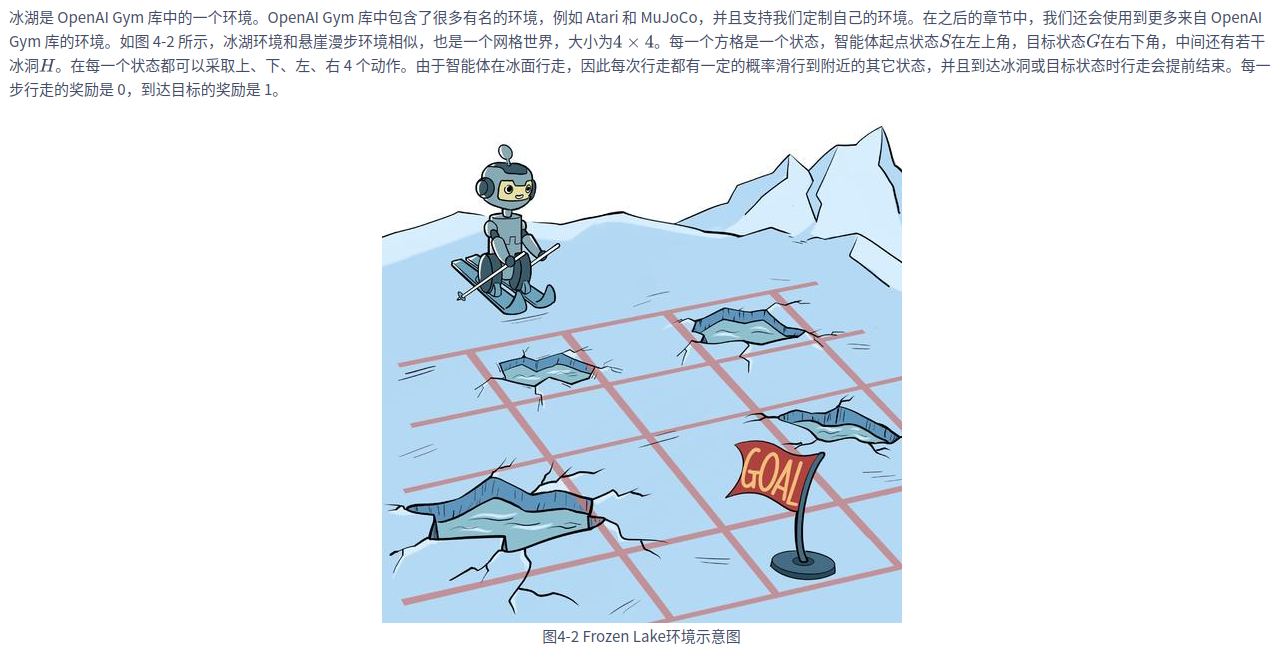

对于所有的环境，必须包含状态转移矩阵，形状为(states_num,s_actions_num,next_states_num,4)  
其中next_states_data是一个tuple包含四个内容:(状态转移概率，下一状态，奖励值，终止与否)  

In [39]:
import gymnasium as gym
env = gym.make("FrozenLake-v1", render_mode="rgb_array")  # 创建环境
env = env.unwrapped  # 解封装才能访问状态转移矩阵P
env.reset()  # 关键修正：初始化环境状态
env.render()  # 环境渲染,通常是弹窗显示或打印出可视化的环境

holes = set()
ends = set()
for s in env.P:
    for a in env.P[s]:
        for next_s in env.P[s][a]:
            if next_s[2] == 1.0:  # 获得奖励为1,代表是目标
                ends.add(next_s[1])
            if next_s[3] == True:
                holes.add(next_s[1])
holes = holes - ends
print("环境形状为：","行：",env.nrow,"；列：",env.ncol)
print("起点的索引:",env.s)
print("冰洞的索引:", holes)
print("目标的索引:", ends)

for i in range(env.nrow):
    shape=""
    for j in range(env.ncol):
        if i*env.ncol+j==env.s:
            shape+=("S"+" ")
        elif i*env.ncol+j in holes:
            shape+=("O"+" ")
        elif i*env.ncol+j in ends:
            shape+="E"+" "
        else :
            shape+="A"+" "
    print(shape)
    
for a in env.P[14]:  # 查看目标左边一格的状态转移信息
    print(env.P[14][a])

# SFFF
# FHFH
# FFFH
# HFFG

环境形状为： 行： 4 ；列： 4
起点的索引: 0
冰洞的索引: {11, 12, 5, 7}
目标的索引: {15}
S A A A 
A O A O 
A A A O 
O A A E 
[(0.33333333333333337, 10, 0, False), (0.3333333333333333, 13, 0, False), (0.33333333333333337, 14, 0, False)]
[(0.33333333333333337, 13, 0, False), (0.3333333333333333, 14, 0, False), (0.33333333333333337, 15, 1, True)]
[(0.33333333333333337, 14, 0, False), (0.3333333333333333, 15, 1, True), (0.33333333333333337, 10, 0, False)]
[(0.33333333333333337, 15, 1, True), (0.3333333333333333, 10, 0, False), (0.33333333333333337, 13, 0, False)]


In [40]:
# 这个动作意义是Gym库针对冰湖环境事先规定好的
action_meaning = ['<', 'v', '>', '^']
theta = 1e-5
gamma = 0.9
agent = PolicyIteration(env, theta, gamma)
agent.policy_iteration()
print_agent(agent, action_meaning, [5, 7, 11, 12], [15])


策略评估进行25轮后完成
策略提升完成
策略评估进行58轮后完成
策略提升完成
状态价值：
 0.069  0.061  0.074  0.056 
 0.092  0.000  0.112  0.000 
 0.145  0.247  0.300  0.000 
 0.000  0.380  0.639  0.000 
策略：
<ooo ooo^ <ooo ooo^ 
<ooo **** <o>o **** 
ooo^ ovoo <ooo **** 
**** oo>o ovoo EEEE 


In [41]:
action_meaning = ['<', 'v', '>', '^']
theta = 1e-5
gamma = 0.9
agent = ValueIteration(env, theta, gamma)
agent.value_iteration()
print_agent(agent, action_meaning, [5, 7, 11, 12], [15])


价值迭代一共进行60轮
状态价值：
 0.069  0.061  0.074  0.056 
 0.092  0.000  0.112  0.000 
 0.145  0.247  0.300  0.000 
 0.000  0.380  0.639  0.000 
策略：
<ooo ooo^ <ooo ooo^ 
<ooo **** <o>o **** 
ooo^ ovoo <ooo **** 
**** oo>o ovoo EEEE 


In [42]:
disaster,ends=[5, 7, 11, 12], [15]
action_meaning = ['^', 'v', '<', '>']
epsilon = 0.00001
delta=0.01
iter_num=200
gamma = 0.9
max_step=100
sample_num=50
agent = MC_Algrithm(env, epsilon, gamma,max_step,delta)
agent.Set_End_Disaster(ends,disaster)
agent.MC_iteration(sample_num,iter_num)
print_agent(agent, action_meaning, disaster,ends)

第10轮策略提升,策略最大误差0.9999899999999999
第20轮策略提升,策略最大误差0.9999899999999999
第30轮策略提升,策略最大误差0.9999899999999999
第40轮策略提升,策略最大误差0.9999899999999999
第50轮策略提升,策略最大误差0.9999899999999999
第60轮策略提升,策略最大误差0.9999899999999999
第70轮策略提升,策略最大误差0.9999899999999999
第80轮策略提升,策略最大误差0.9999899999999999
第90轮策略提升,策略最大误差0.9999899999999999
第100轮策略提升,策略最大误差0.9999899999999999
第110轮策略提升,策略最大误差0.9999899999999999
第120轮策略提升,策略最大误差0.9999899999999999
第130轮策略提升,策略最大误差0.9999899999999999
第140轮策略提升,策略最大误差0.9999899999999999
第150轮策略提升,策略最大误差0.9999899999999999
第160轮策略提升,策略最大误差0.9999899999999999
第170轮策略提升,策略最大误差0.9999899999999999
第180轮策略提升,策略最大误差0.9999899999999999
第190轮策略提升,策略最大误差0.9999899999999999
第200轮策略提升,策略最大误差0.9999899999999999
策略优化完成
状态价值：
 0.062  0.029  0.074  0.028 
 0.095  0.000  0.168  0.000 
 0.136  0.260  0.260  0.000 
 0.000  0.352  0.654  0.000 
策略：
oo<o ooo> oo<o ^ooo 
ovoo **** ^ooo **** 
ovoo ovoo ^ooo **** 
**** oo<o ovoo EEEE 
